Playing with decision trees.

In [1]:
import pandas as pd

In [2]:
from sklearn import datasets
iris = datasets.load_iris()

In [3]:
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [4]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [6]:
df['target'] = pd.Series(iris.target)

In [7]:
df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
102,7.1,3.0,5.9,2.1,2
141,6.9,3.1,5.1,2.3,2
28,5.2,3.4,1.4,0.2,0
73,6.1,2.8,4.7,1.2,1
7,5.0,3.4,1.5,0.2,0


In [8]:
df['target names'] = df['target'].apply(lambda y : iris.target_names[y])

In [9]:
df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target names
65,6.7,3.1,4.4,1.4,1,versicolor
68,6.2,2.2,4.5,1.5,1,versicolor
10,5.4,3.7,1.5,0.2,0,setosa
90,5.5,2.6,4.4,1.2,1,versicolor
26,5.0,3.4,1.6,0.4,0,setosa


In [10]:
df['target names'].unique()  #three output labels

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size= 0.3)

In [12]:
xtrain = df_train[iris.feature_names]
xtest = df_test[iris.feature_names]

ytrain = df_train['target']
ytest = df_test['target']

In [13]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

In [14]:
clf.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [15]:
ytest_pred = clf.predict(xtest)

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ytest_pred)

0.9333333333333333

In [17]:
pd.DataFrame({'feature_names' : iris.feature_names, 'feature_importances' : clf.feature_importances_}).sort_values('feature_importances', ascending= False ).set_index('feature_names')

,feature_importances
feature_names,
petal length (cm),0.564647
petal width (cm),0.435353
sepal length (cm),0.000000
sepal width (cm),0.000000


Prevent Overfitting: Allowing a tree to grow so much results in overfitting. To prevent it, we can set __max_depth__ , __min_samples_split__ , __min_samples_leaf__ 

#### Shuffle split
 - in sklearn, it performs Monte Carlo cross - validation. Monte Carlo methods make use of random sampling in order to repeat an experiment over and over to reach better estimates for the results


"Cross-validation is a technique that involves systematically generating multiple train and test splits from the dataset to evaluate the model's performance on unseen data."

In [18]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

clf = DecisionTreeClassifier()

rs = ShuffleSplit(n_splits=100, test_size=0.3)  #here, we randomly split the dataset into 100 training and test pairs
x = df[iris.feature_names]
y = df['target']

cv_results = cross_validate(clf, x, y, cv = rs, scoring="accuracy")

accuracy_scores = pd.Series(cv_results['test_score'])

In [21]:
accuracy_scores.mean()

0.9493333333333333

<Axes: title={'center': 'Distribution of Classifier Accuracy'}>

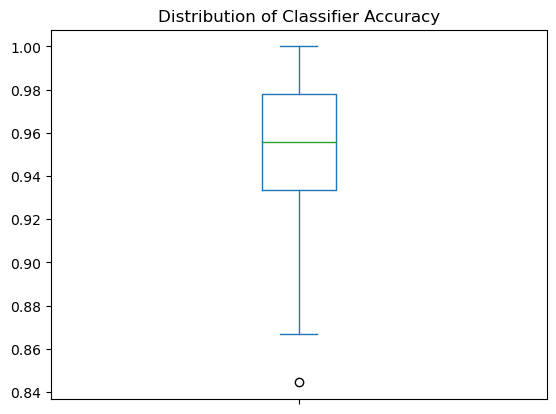

In [27]:
accuracy_scores.plot(title = 'Distribution of Classifier Accuracy', kind = 'box')